In [1]:
import sys
import platform
import src.data.reader as rd
from pathlib import PurePath
from multiprocessing import cpu_count
from src.utils.utils import *

print('Python %s on %s' % (sys.version, sys.platform))

pdir = get_relative_project_dir('FinML', partial=False)
# for notebook references
sys.path.extend([pdir])
print(pdir)

data_dir = pdir / 'data'
data_raw_dir = data_dir / 'raw'
data_interim_dir = data_dir / 'interim'
data_processed_dir = data_dir / 'processed'
file_name = 'IVE_tickbidask'

/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] on darwin
/Users/scottblunsden/Programs/FinML


In [2]:
# Uncomment out to read from a raw data and save to a parquet file
# some code to download from internet goes here
#reader = rd.Reader()
#txt_file_name = file_name + '.txt'
#infp = PurePath(data_raw_dir / txt_file_name)
#df = reader.read_kibot_ticks(infp)

#parq_file_name = file_name+'.parq'
#outfp = PurePath(data_raw_dir / parq_file_name)

# Save file to parquet
#df.to_parquet(outfp)


In [3]:
# Load from parquet
parq_file_name = file_name + '.parq'
infp = PurePath(data_raw_dir / parq_file_name)
df = pd.read_parquet(infp)


/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/scottblunsden/anaconda3/envs/FinML/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
import src.features.datacleaner as dc

data_cleaner = dc.DataCleaner()

df = data_cleaner.remove_outliers(df, 'price')
df = df.resample('1T').sum().drop_duplicates().dropna()

In [5]:
import src.features.bars as bar
import src.features.labeller as lab

bars = bar.Bars()
dbars = bars.dollar_bar_df(df, 'dv', 10_000).drop_duplicates().dropna()

close = dbars.price.copy()
labeller = lab.Labeller()
dailyVol = labeller.getDailyVol(close).dropna()


  0%|          | 0/565466 [00:00<?, ?it/s]

 22%|██▏       | 125225/565466 [00:00<00:00, 1252239.25it/s]

 46%|████▌     | 259371/565466 [00:00<00:00, 1277733.42it/s]

 70%|███████   | 397061/565466 [00:00<00:00, 1305947.24it/s]

 97%|█████████▋| 549645/565466 [00:00<00:00, 1364959.07it/s]

100%|██████████| 565466/565466 [00:00<00:00, 1379030.31it/s]

In [6]:
import src.strategy.crossover as cross
crossover = cross.MACrossover()

fast_window = 3
slow_window = 7


side = crossover.get_side(close, fast_window, slow_window)


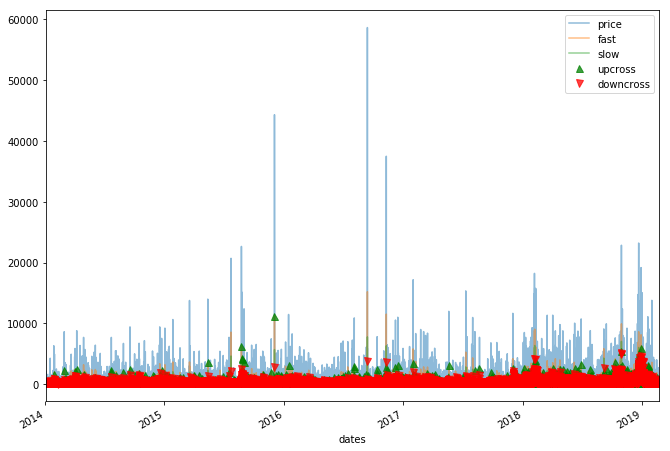

In [7]:
import matplotlib.pyplot as plt

close_df = crossover.close_df(close, fast_window, slow_window)
up = crossover.get_up_cross(close_df)
down = crossover.get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [8]:
tEvents = labeller.getTEvents(close_df['price'], h=dailyVol.mean())
t1 = labeller.addVerticalBarrier(tEvents, close_df['price'], numDays=1)

target = dailyVol

# Run in single-threaded mode on Windows

if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1

minRet = .01 
ptsl=[1, 2]

ma_events = labeller.getEvents(close_df['price'], tEvents, ptsl, target, minRet, cpus, t1=t1, side=side)

ma_side = ma_events.dropna().side
ma_bins = labeller.getBinsNew(ma_events, close_df['price'], t1).dropna()

Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')

data_processed_dir = data_dir / 'processed'
parq_file_name = file_name + '_crossover_train_test.parq'

outfp = PurePath(data_processed_dir / parq_file_name)

Xx.to_parquet(outfp)

  0%|          | 0/521229 [00:00<?, ?it/s]

  0%|          | 225/521229 [00:00<03:51, 2248.14it/s]

  0%|          | 887/521229 [00:00<03:05, 2802.51it/s]

  0%|          | 1614/521229 [00:00<02:31, 3435.85it/s]

  0%|          | 2343/521229 [00:00<02:07, 4083.20it/s]

  1%|          | 3118/521229 [00:00<01:48, 4757.63it/s]

  1%|          | 3899/521229 [00:00<01:36, 5388.46it/s]

  1%|          | 4641/521229 [00:00<01:28, 5869.96it/s]

  1%|          | 5391/521229 [00:00<01:22, 6279.00it/s]

  1%|          | 6162/521229 [00:00<01:17, 6648.99it/s]

  1%|▏         | 6934/521229 [00:01<01:14, 6936.86it/s]

  1%|▏         | 7720/521229 [00:01<01:11, 7190.16it/s]

  2%|▏         | 8495/521229 [00:01<01:09, 7348.03it/s]

  2%|▏         | 9268/521229 [00:01<01:08, 7457.57it/s]

  2%|▏         | 10046/521229 [00:01<01:07, 7549.14it/s]

  2%|▏         | 10813/521229 [00:01<01:07, 7577.47it/s]

  2%|▏         | 11603/521229 [00:01<01:06, 7671.09it/s]

  2%|▏         | 12383/521229 [00:01<01:06, 7707.69it/s]

  3%|▎         | 13166/521229 [00:01<01:05, 7743.59it/s]

  3%|▎         | 13955/521229 [00:01<01:05, 7785.00it/s]

  3%|▎         | 14741/521229 [00:02<01:04, 7807.03it/s]

  3%|▎         | 15543/521229 [00:02<01:04, 7868.93it/s]

  3%|▎         | 16332/521229 [00:02<01:04, 7833.44it/s]

  3%|▎         | 17117/521229 [00:02<01:04, 7823.52it/s]

  3%|▎         | 17907/521229 [00:02<01:04, 7844.32it/s]

  4%|▎         | 18700/521229 [00:02<01:03, 7869.39it/s]

  4%|▎         | 19489/521229 [00:02<01:03, 7874.27it/s]

  4%|▍         | 20279/521229 [00:02<01:03, 7879.82it/s]

  4%|▍         | 21069/521229 [00:02<01:03, 7885.60it/s]

  4%|▍         | 21858/521229 [00:02<01:03, 7873.08it/s]

  4%|▍         | 22646/521229 [00:03<01:03, 7813.06it/s]

  4%|▍         | 23445/521229 [00:03<01:03, 7864.85it/s]

  5%|▍         | 24232/521229 [00:03<01:03, 7835.97it/s]

  5%|▍         | 25016/521229 [00:03<01:03, 7807.67it/s]

  5%|▍         | 25799/521229 [00:03<01:03, 7812.75it/s]

  5%|▌         | 26582/521229 [00:03<01:03, 7816.27it/s]

  5%|▌         | 27364/521229 [00:03<01:03, 7814.84it/s]

  5%|▌         | 28149/521229 [00:03<01:03, 7824.72it/s]

  6%|▌         | 28932/521229 [00:03<01:03, 7771.96it/s]

  6%|▌         | 29722/521229 [00:03<01:02, 7808.04it/s]

  6%|▌         | 30508/521229 [00:04<01:02, 7822.06it/s]

  6%|▌         | 31291/521229 [00:04<01:02, 7792.90it/s]

  6%|▌         | 32071/521229 [00:04<01:02, 7792.75it/s]

  6%|▋         | 32866/521229 [00:04<01:02, 7837.23it/s]

  6%|▋         | 33650/521229 [00:04<01:02, 7806.61it/s]

  7%|▋         | 34431/521229 [00:04<01:02, 7797.03it/s]

  7%|▋         | 35219/521229 [00:04<01:02, 7821.51it/s]

  7%|▋         | 36009/521229 [00:04<01:01, 7841.99it/s]

  7%|▋         | 36801/521229 [00:04<01:01, 7862.59it/s]

  7%|▋         | 37596/521229 [00:04<01:01, 7885.96it/s]

  7%|▋         | 38385/521229 [00:05<01:01, 7852.57it/s]

  8%|▊         | 39171/521229 [00:05<01:02, 7751.02it/s]

  8%|▊         | 39947/521229 [00:05<01:02, 7681.66it/s]

  8%|▊         | 40734/521229 [00:05<01:02, 7735.52it/s]

  8%|▊         | 41511/521229 [00:05<01:01, 7745.58it/s]

  8%|▊         | 42288/521229 [00:05<01:01, 7750.68it/s]

  8%|▊         | 43080/521229 [00:05<01:01, 7799.88it/s]

  8%|▊         | 43869/521229 [00:05<01:01, 7824.44it/s]

  9%|▊         | 44657/521229 [00:05<01:00, 7838.88it/s]

  9%|▊         | 45450/521229 [00:05<01:00, 7864.26it/s]

  9%|▉         | 46237/521229 [00:06<01:00, 7862.59it/s]

  9%|▉         | 47024/521229 [00:06<01:00, 7835.84it/s]

  9%|▉         | 47808/521229 [00:06<01:00, 7830.04it/s]

  9%|▉         | 48598/521229 [00:06<01:00, 7848.47it/s]

  9%|▉         | 49383/521229 [00:06<01:00, 7810.83it/s]

 10%|▉         | 50170/521229 [00:06<01:00, 7826.92it/s]

 10%|▉         | 50953/521229 [00:06<01:00, 7827.33it/s]

 10%|▉         | 51736/521229 [00:06<01:00, 7819.17it/s]

 10%|█         | 52518/521229 [00:06<01:00, 7806.93it/s]

 10%|█         | 53299/521229 [00:06<01:00, 7777.02it/s]

 10%|█         | 54094/521229 [00:07<00:59, 7826.15it/s]

 11%|█         | 54877/521229 [00:07<00:59, 7808.39it/s]

 11%|█         | 55658/521229 [00:07<00:59, 7760.68it/s]

 11%|█         | 56440/521229 [00:07<00:59, 7777.50it/s]

 11%|█         | 57225/521229 [00:07<00:59, 7798.22it/s]

 11%|█         | 58007/521229 [00:07<00:59, 7803.86it/s]

 11%|█▏        | 58799/521229 [00:07<00:59, 7837.65it/s]

 11%|█▏        | 59584/521229 [00:07<00:58, 7838.66it/s]

 12%|█▏        | 60368/521229 [00:07<00:58, 7828.01it/s]

 12%|█▏        | 61155/521229 [00:07<00:58, 7838.82it/s]

 12%|█▏        | 61939/521229 [00:08<00:58, 7836.78it/s]

 12%|█▏        | 62729/521229 [00:08<00:58, 7854.68it/s]

 12%|█▏        | 63521/521229 [00:08<00:58, 7871.77it/s]

 12%|█▏        | 64309/521229 [00:08<00:58, 7860.50it/s]

 12%|█▏        | 65096/521229 [00:08<00:58, 7816.30it/s]

 13%|█▎        | 65885/521229 [00:08<00:58, 7836.37it/s]

 13%|█▎        | 66671/521229 [00:08<00:57, 7840.72it/s]

 13%|█▎        | 67468/521229 [00:08<00:57, 7877.73it/s]

 13%|█▎        | 68256/521229 [00:08<00:57, 7849.12it/s]

 13%|█▎        | 69052/521229 [00:08<00:57, 7881.43it/s]

 13%|█▎        | 69841/521229 [00:09<00:57, 7805.26it/s]

 14%|█▎        | 70622/521229 [00:09<00:58, 7733.81it/s]

 14%|█▎        | 71417/521229 [00:09<00:57, 7796.55it/s]

 14%|█▍        | 72205/521229 [00:09<00:57, 7818.77it/s]

 14%|█▍        | 72988/521229 [00:09<00:58, 7721.57it/s]

 14%|█▍        | 73774/521229 [00:09<00:57, 7762.28it/s]

 14%|█▍        | 74551/521229 [00:09<00:57, 7761.52it/s]

 14%|█▍        | 75328/521229 [00:09<00:57, 7712.94it/s]

 15%|█▍        | 76102/521229 [00:09<00:57, 7720.44it/s]

 15%|█▍        | 76881/521229 [00:09<00:57, 7739.24it/s]

 15%|█▍        | 77665/521229 [00:10<00:57, 7767.53it/s]

 15%|█▌        | 78442/521229 [00:10<00:57, 7748.96it/s]

 15%|█▌        | 79217/521229 [00:10<00:57, 7736.70it/s]

 15%|█▌        | 80000/521229 [00:10<00:56, 7763.76it/s]

 15%|█▌        | 80777/521229 [00:10<00:56, 7753.33it/s]

 16%|█▌        | 81563/521229 [00:10<00:56, 7782.74it/s]

 16%|█▌        | 82345/521229 [00:10<00:56, 7792.71it/s]

 16%|█▌        | 83128/521229 [00:10<00:56, 7801.11it/s]

 16%|█▌        | 83918/521229 [00:10<00:55, 7829.71it/s]

 16%|█▋        | 84704/521229 [00:10<00:55, 7837.67it/s]

 16%|█▋        | 85493/521229 [00:11<00:55, 7851.42it/s]

 17%|█▋        | 86296/521229 [00:11<00:55, 7901.00it/s]

 17%|█▋        | 87087/521229 [00:11<00:55, 7881.84it/s]

 17%|█▋        | 87880/521229 [00:11<00:54, 7895.91it/s]

 17%|█▋        | 88670/521229 [00:11<00:55, 7846.51it/s]

 17%|█▋        | 89455/521229 [00:11<00:55, 7819.25it/s]

 17%|█▋        | 90251/521229 [00:11<00:54, 7859.86it/s]

 17%|█▋        | 91048/521229 [00:11<00:54, 7892.34it/s]

 18%|█▊        | 91838/521229 [00:11<00:54, 7832.07it/s]

 18%|█▊        | 92622/521229 [00:11<00:54, 7833.27it/s]

 18%|█▊        | 93406/521229 [00:12<00:54, 7804.03it/s]

 18%|█▊        | 94188/521229 [00:12<00:54, 7808.62it/s]

 18%|█▊        | 94969/521229 [00:12<00:54, 7796.62it/s]

 18%|█▊        | 95749/521229 [00:12<00:54, 7794.74it/s]

 19%|█▊        | 96529/521229 [00:12<00:54, 7786.01it/s]

 19%|█▊        | 97316/521229 [00:12<00:54, 7809.32it/s]

 19%|█▉        | 98097/521229 [00:12<00:54, 7808.57it/s]

 19%|█▉        | 98894/521229 [00:12<00:53, 7853.96it/s]

 19%|█▉        | 99680/521229 [00:12<00:53, 7828.26it/s]

 19%|█▉        | 100463/521229 [00:12<00:53, 7792.60it/s]

 19%|█▉        | 101243/521229 [00:13<00:53, 7781.70it/s]

 20%|█▉        | 102035/521229 [00:13<00:53, 7821.43it/s]

 20%|█▉        | 102824/521229 [00:13<00:53, 7840.83it/s]

 20%|█▉        | 103609/521229 [00:13<00:53, 7812.85it/s]

 20%|██        | 104391/521229 [00:13<00:53, 7778.52it/s]

 20%|██        | 105169/521229 [00:13<00:53, 7762.59it/s]

 20%|██        | 105946/521229 [00:13<00:53, 7736.45it/s]

 20%|██        | 106730/521229 [00:13<00:53, 7766.25it/s]

 21%|██        | 107520/521229 [00:13<00:53, 7804.05it/s]

 21%|██        | 108303/521229 [00:13<00:52, 7810.97it/s]

 21%|██        | 109096/521229 [00:14<00:52, 7846.00it/s]

 21%|██        | 109894/521229 [00:14<00:52, 7883.69it/s]

 21%|██        | 110683/521229 [00:14<00:52, 7858.82it/s]

 21%|██▏       | 111472/521229 [00:14<00:52, 7866.12it/s]

 22%|██▏       | 112259/521229 [00:14<00:52, 7821.43it/s]

 22%|██▏       | 113042/521229 [00:14<00:52, 7811.66it/s]

 22%|██▏       | 113826/521229 [00:14<00:52, 7819.62it/s]

 22%|██▏       | 114618/521229 [00:14<00:51, 7846.97it/s]

 22%|██▏       | 115405/521229 [00:14<00:51, 7851.72it/s]

 22%|██▏       | 116191/521229 [00:14<00:51, 7840.11it/s]

 22%|██▏       | 116976/521229 [00:15<00:51, 7814.52it/s]

 23%|██▎       | 117764/521229 [00:15<00:51, 7832.18it/s]

 23%|██▎       | 118548/521229 [00:15<00:51, 7796.85it/s]

 23%|██▎       | 119330/521229 [00:15<00:51, 7801.91it/s]

 23%|██▎       | 120112/521229 [00:15<00:51, 7806.96it/s]

 23%|██▎       | 120893/521229 [00:15<00:51, 7800.65it/s]

 23%|██▎       | 121681/521229 [00:15<00:51, 7822.92it/s]

 23%|██▎       | 122471/521229 [00:15<00:50, 7844.05it/s]

 24%|██▎       | 123261/521229 [00:15<00:50, 7858.56it/s]

 24%|██▍       | 124056/521229 [00:15<00:50, 7883.34it/s]

 24%|██▍       | 124847/521229 [00:16<00:50, 7889.17it/s]

 24%|██▍       | 125636/521229 [00:16<00:50, 7830.95it/s]

 24%|██▍       | 126420/521229 [00:16<00:50, 7807.89it/s]

 24%|██▍       | 127202/521229 [00:16<00:50, 7809.74it/s]

 25%|██▍       | 127984/521229 [00:16<00:50, 7730.52it/s]

 25%|██▍       | 128771/521229 [00:16<00:50, 7769.50it/s]

 25%|██▍       | 129558/521229 [00:16<00:50, 7796.29it/s]

 25%|██▌       | 130338/521229 [00:16<00:50, 7786.64it/s]

 25%|██▌       | 131126/521229 [00:16<00:49, 7813.86it/s]

 25%|██▌       | 131908/521229 [00:16<00:49, 7812.23it/s]

 25%|██▌       | 132690/521229 [00:17<00:49, 7772.36it/s]

 26%|██▌       | 133485/521229 [00:17<00:49, 7822.18it/s]

 26%|██▌       | 134269/521229 [00:17<00:49, 7826.80it/s]

 26%|██▌       | 135052/521229 [00:17<00:49, 7814.56it/s]

 26%|██▌       | 135834/521229 [00:17<00:49, 7806.10it/s]

 26%|██▌       | 136619/521229 [00:17<00:49, 7818.89it/s]

 26%|██▋       | 137401/521229 [00:17<00:49, 7796.94it/s]

 27%|██▋       | 138181/521229 [00:17<00:49, 7797.36it/s]

 27%|██▋       | 138961/521229 [00:17<00:49, 7765.90it/s]

 27%|██▋       | 139740/521229 [00:17<00:49, 7772.11it/s]

 27%|██▋       | 140518/521229 [00:18<00:49, 7769.44it/s]

 27%|██▋       | 141302/521229 [00:18<00:48, 7788.97it/s]

 27%|██▋       | 142081/521229 [00:18<00:48, 7784.77it/s]

 27%|██▋       | 142867/521229 [00:18<00:48, 7806.19it/s]

 28%|██▊       | 143648/521229 [00:18<00:48, 7721.38it/s]

 28%|██▊       | 144436/521229 [00:18<00:48, 7766.89it/s]

 28%|██▊       | 145213/521229 [00:18<00:48, 7748.79it/s]

 28%|██▊       | 145997/521229 [00:18<00:48, 7774.78it/s]

 28%|██▊       | 146775/521229 [00:18<00:48, 7754.05it/s]

 28%|██▊       | 147570/521229 [00:19<00:47, 7810.70it/s]

 28%|██▊       | 148352/521229 [00:19<00:47, 7795.40it/s]

 29%|██▊       | 149134/521229 [00:19<00:47, 7800.83it/s]

 29%|██▉       | 149926/521229 [00:19<00:47, 7836.16it/s]

 29%|██▉       | 150711/521229 [00:19<00:47, 7839.22it/s]

 29%|██▉       | 151495/521229 [00:19<00:47, 7835.93it/s]

 29%|██▉       | 152279/521229 [00:19<00:47, 7828.28it/s]

 29%|██▉       | 153062/521229 [00:19<00:47, 7824.64it/s]

 30%|██▉       | 153854/521229 [00:19<00:46, 7850.55it/s]

 30%|██▉       | 154640/521229 [00:19<00:46, 7853.22it/s]

 30%|██▉       | 155426/521229 [00:20<00:46, 7819.03it/s]

 30%|██▉       | 156210/521229 [00:20<00:46, 7823.37it/s]

 30%|███       | 156998/521229 [00:20<00:46, 7839.76it/s]

 30%|███       | 157783/521229 [00:20<00:46, 7830.74it/s]

 30%|███       | 158567/521229 [00:20<00:46, 7829.15it/s]

 31%|███       | 159350/521229 [00:20<00:46, 7796.94it/s]

 31%|███       | 160136/521229 [00:20<00:46, 7813.53it/s]

 31%|███       | 160931/521229 [00:20<00:45, 7853.42it/s]

 31%|███       | 161717/521229 [00:20<00:46, 7786.10it/s]

 31%|███       | 162496/521229 [00:20<00:46, 7767.38it/s]

 31%|███▏      | 163274/521229 [00:21<00:46, 7768.41it/s]

 31%|███▏      | 164051/521229 [00:21<00:46, 7751.69it/s]

 32%|███▏      | 164832/521229 [00:21<00:45, 7768.00it/s]

 32%|███▏      | 165615/521229 [00:21<00:45, 7784.77it/s]

 32%|███▏      | 166394/521229 [00:21<00:45, 7757.50it/s]

 32%|███▏      | 167179/521229 [00:21<00:45, 7783.80it/s]

 32%|███▏      | 167962/521229 [00:21<00:45, 7796.46it/s]

 32%|███▏      | 168749/521229 [00:21<00:45, 7817.84it/s]

 33%|███▎      | 169531/521229 [00:21<00:45, 7786.93it/s]

 33%|███▎      | 170329/521229 [00:21<00:44, 7841.44it/s]

 33%|███▎      | 171114/521229 [00:22<00:44, 7823.23it/s]

 33%|███▎      | 171897/521229 [00:22<00:44, 7811.93it/s]

 33%|███▎      | 172679/521229 [00:22<00:44, 7803.35it/s]

 33%|███▎      | 173468/521229 [00:22<00:44, 7827.68it/s]

 33%|███▎      | 174251/521229 [00:22<00:44, 7788.34it/s]

 34%|███▎      | 175033/521229 [00:22<00:44, 7797.58it/s]

 34%|███▎      | 175825/521229 [00:22<00:44, 7831.63it/s]

 34%|███▍      | 176609/521229 [00:22<00:44, 7828.41it/s]

 34%|███▍      | 177392/521229 [00:22<00:43, 7823.70it/s]

 34%|███▍      | 178176/521229 [00:22<00:43, 7826.90it/s]

 34%|███▍      | 178959/521229 [00:23<00:43, 7815.34it/s]

 34%|███▍      | 179741/521229 [00:23<00:43, 7803.41it/s]

 35%|███▍      | 180522/521229 [00:23<00:43, 7798.42it/s]

 35%|███▍      | 181302/521229 [00:23<00:43, 7771.50it/s]

 35%|███▍      | 182080/521229 [00:23<00:43, 7736.68it/s]

 35%|███▌      | 182854/521229 [00:23<00:43, 7734.71it/s]

 35%|███▌      | 183628/521229 [00:23<00:43, 7731.10it/s]

 35%|███▌      | 184404/521229 [00:23<00:43, 7739.51it/s]

 36%|███▌      | 185194/521229 [00:23<00:43, 7786.95it/s]

 36%|███▌      | 185973/521229 [00:23<00:43, 7780.33it/s]

 36%|███▌      | 186760/521229 [00:24<00:42, 7804.83it/s]

 36%|███▌      | 187541/521229 [00:24<00:42, 7776.14it/s]

 36%|███▌      | 188319/521229 [00:24<00:43, 7736.09it/s]

 36%|███▋      | 189096/521229 [00:24<00:42, 7743.64it/s]

 36%|███▋      | 189871/521229 [00:24<00:42, 7718.53it/s]

 37%|███▋      | 190645/521229 [00:24<00:42, 7723.02it/s]

 37%|███▋      | 191438/521229 [00:24<00:42, 7782.21it/s]

 37%|███▋      | 192226/521229 [00:24<00:42, 7811.10it/s]

 37%|███▋      | 193008/521229 [00:24<00:42, 7770.07it/s]

 37%|███▋      | 193786/521229 [00:24<00:42, 7759.07it/s]

 37%|███▋      | 194573/521229 [00:25<00:41, 7790.15it/s]

 37%|███▋      | 195353/521229 [00:25<00:41, 7774.26it/s]

 38%|███▊      | 196131/521229 [00:25<00:41, 7765.67it/s]

 38%|███▊      | 196925/521229 [00:25<00:41, 7816.60it/s]

 38%|███▊      | 197707/521229 [00:25<00:41, 7809.17it/s]

 38%|███▊      | 198489/521229 [00:25<00:41, 7794.71it/s]

 38%|███▊      | 199269/521229 [00:25<00:41, 7754.18it/s]

 38%|███▊      | 200051/521229 [00:25<00:41, 7773.23it/s]

 39%|███▊      | 200829/521229 [00:25<00:41, 7763.42it/s]

 39%|███▊      | 201610/521229 [00:25<00:41, 7776.42it/s]

 39%|███▉      | 202388/521229 [00:26<00:41, 7757.16it/s]

 39%|███▉      | 203165/521229 [00:26<00:40, 7759.50it/s]

 39%|███▉      | 203948/521229 [00:26<00:40, 7779.94it/s]

 39%|███▉      | 204729/521229 [00:26<00:40, 7788.05it/s]

 39%|███▉      | 205508/521229 [00:26<00:40, 7759.68it/s]

 40%|███▉      | 206292/521229 [00:26<00:40, 7780.94it/s]

 40%|███▉      | 207081/521229 [00:26<00:40, 7811.44it/s]

 40%|███▉      | 207863/521229 [00:26<00:40, 7804.28it/s]

 40%|████      | 208644/521229 [00:26<00:40, 7765.04it/s]

 40%|████      | 209430/521229 [00:26<00:40, 7790.62it/s]

 40%|████      | 210221/521229 [00:27<00:39, 7824.70it/s]

 40%|████      | 211004/521229 [00:27<00:39, 7814.32it/s]

 41%|████      | 211788/521229 [00:27<00:39, 7819.38it/s]

 41%|████      | 212570/521229 [00:27<00:39, 7787.40it/s]

 41%|████      | 213349/521229 [00:27<00:39, 7758.00it/s]

 41%|████      | 214134/521229 [00:27<00:39, 7785.31it/s]

 41%|████      | 214915/521229 [00:27<00:39, 7790.57it/s]

 41%|████▏     | 215698/521229 [00:27<00:39, 7800.52it/s]

 42%|████▏     | 216479/521229 [00:27<00:39, 7791.80it/s]

 42%|████▏     | 217264/521229 [00:27<00:38, 7808.19it/s]

 42%|████▏     | 218045/521229 [00:28<00:38, 7801.94it/s]

 42%|████▏     | 218826/521229 [00:28<00:38, 7787.88it/s]

 42%|████▏     | 219605/521229 [00:28<00:38, 7772.88it/s]

 42%|████▏     | 220390/521229 [00:28<00:38, 7793.33it/s]

 42%|████▏     | 221170/521229 [00:28<00:38, 7763.11it/s]

 43%|████▎     | 221953/521229 [00:28<00:38, 7782.51it/s]

 43%|████▎     | 222739/521229 [00:28<00:38, 7803.03it/s]

 43%|████▎     | 223520/521229 [00:28<00:38, 7792.20it/s]

 43%|████▎     | 224300/521229 [00:28<00:38, 7775.01it/s]

 43%|████▎     | 225102/521229 [00:28<00:37, 7845.91it/s]

 43%|████▎     | 225890/521229 [00:29<00:37, 7855.56it/s]

 43%|████▎     | 226679/521229 [00:29<00:37, 7864.24it/s]

 44%|████▎     | 227470/521229 [00:29<00:37, 7875.88it/s]

 44%|████▍     | 228258/521229 [00:29<00:37, 7837.71it/s]

 44%|████▍     | 229042/521229 [00:29<00:37, 7816.31it/s]

 44%|████▍     | 229844/521229 [00:29<00:36, 7875.83it/s]

 44%|████▍     | 230632/521229 [00:29<00:36, 7863.05it/s]

 44%|████▍     | 231419/521229 [00:29<00:36, 7864.10it/s]

 45%|████▍     | 232209/521229 [00:29<00:36, 7873.59it/s]

 45%|████▍     | 232997/521229 [00:29<00:36, 7868.25it/s]

 45%|████▍     | 233784/521229 [00:30<00:36, 7843.62it/s]

 45%|████▌     | 234569/521229 [00:30<00:36, 7822.29it/s]

 45%|████▌     | 235352/521229 [00:30<00:36, 7822.07it/s]

 45%|████▌     | 236135/521229 [00:30<00:36, 7824.21it/s]

 45%|████▌     | 236918/521229 [00:30<00:36, 7778.02it/s]

 46%|████▌     | 237696/521229 [00:30<00:36, 7770.36it/s]

 46%|████▌     | 238474/521229 [00:30<00:36, 7757.88it/s]

 46%|████▌     | 239252/521229 [00:30<00:36, 7761.99it/s]

 46%|████▌     | 240040/521229 [00:30<00:36, 7796.17it/s]

 46%|████▌     | 240820/521229 [00:30<00:36, 7764.18it/s]

 46%|████▋     | 241614/521229 [00:31<00:35, 7813.80it/s]

 47%|████▋     | 242396/521229 [00:31<00:35, 7784.34it/s]

 47%|████▋     | 243183/521229 [00:31<00:35, 7809.63it/s]

 47%|████▋     | 243975/521229 [00:31<00:35, 7840.72it/s]

 47%|████▋     | 244760/521229 [00:31<00:35, 7835.79it/s]

 47%|████▋     | 245551/521229 [00:31<00:35, 7857.26it/s]

 47%|████▋     | 246344/521229 [00:31<00:34, 7878.18it/s]

 47%|████▋     | 247132/521229 [00:31<00:34, 7869.83it/s]

 48%|████▊     | 247920/521229 [00:31<00:34, 7862.23it/s]

 48%|████▊     | 248707/521229 [00:31<00:34, 7835.31it/s]

 48%|████▊     | 249494/521229 [00:32<00:34, 7845.15it/s]

 48%|████▊     | 250279/521229 [00:32<00:34, 7826.96it/s]

 48%|████▊     | 251067/521229 [00:32<00:34, 7841.98it/s]

 48%|████▊     | 251852/521229 [00:32<00:34, 7822.34it/s]

 48%|████▊     | 252635/521229 [00:32<00:34, 7813.18it/s]

 49%|████▊     | 253417/521229 [00:32<00:34, 7807.46it/s]

 49%|████▉     | 254203/521229 [00:32<00:34, 7821.96it/s]

 49%|████▉     | 254986/521229 [00:32<00:34, 7816.68it/s]

 49%|████▉     | 255771/521229 [00:32<00:33, 7824.24it/s]

 49%|████▉     | 256555/521229 [00:32<00:33, 7827.51it/s]

 49%|████▉     | 257338/521229 [00:33<00:33, 7821.94it/s]

 50%|████▉     | 258121/521229 [00:33<00:33, 7821.50it/s]

 50%|████▉     | 258904/521229 [00:33<00:33, 7784.84it/s]

 50%|████▉     | 259683/521229 [00:33<00:33, 7773.91it/s]

 50%|████▉     | 260461/521229 [00:33<00:33, 7766.79it/s]

 50%|█████     | 261248/521229 [00:33<00:33, 7797.14it/s]

 50%|█████     | 262028/521229 [00:33<00:33, 7793.70it/s]

 50%|█████     | 262808/521229 [00:33<00:33, 7777.05it/s]

 51%|█████     | 263598/521229 [00:33<00:32, 7810.70it/s]

 51%|█████     | 264384/521229 [00:33<00:32, 7823.80it/s]

 51%|█████     | 265177/521229 [00:34<00:32, 7853.56it/s]

 51%|█████     | 265963/521229 [00:34<00:32, 7811.37it/s]

 51%|█████     | 266746/521229 [00:34<00:32, 7816.69it/s]

 51%|█████▏    | 267532/521229 [00:34<00:32, 7828.74it/s]

 51%|█████▏    | 268315/521229 [00:34<00:32, 7764.95it/s]

 52%|█████▏    | 269104/521229 [00:34<00:32, 7801.46it/s]

 52%|█████▏    | 269890/521229 [00:34<00:32, 7816.79it/s]

 52%|█████▏    | 270672/521229 [00:34<00:32, 7812.27it/s]

 52%|█████▏    | 271460/521229 [00:34<00:31, 7831.32it/s]

 52%|█████▏    | 272251/521229 [00:34<00:31, 7853.78it/s]

 52%|█████▏    | 273037/521229 [00:35<00:31, 7815.20it/s]

 53%|█████▎    | 273819/521229 [00:35<00:31, 7804.75it/s]

 53%|█████▎    | 274608/521229 [00:35<00:31, 7829.39it/s]

 53%|█████▎    | 275392/521229 [00:35<00:31, 7776.22it/s]

 53%|█████▎    | 276170/521229 [00:35<00:31, 7752.66it/s]

 53%|█████▎    | 276959/521229 [00:35<00:31, 7791.14it/s]

 53%|█████▎    | 277743/521229 [00:35<00:31, 7805.45it/s]

 53%|█████▎    | 278527/521229 [00:35<00:31, 7814.92it/s]

 54%|█████▎    | 279319/521229 [00:35<00:30, 7844.26it/s]

 54%|█████▎    | 280104/521229 [00:35<00:30, 7811.58it/s]

 54%|█████▍    | 280891/521229 [00:36<00:30, 7828.94it/s]

 54%|█████▍    | 281674/521229 [00:36<00:30, 7804.41it/s]

 54%|█████▍    | 282461/521229 [00:36<00:30, 7821.34it/s]

 54%|█████▍    | 283251/521229 [00:36<00:30, 7842.32it/s]

 54%|█████▍    | 284042/521229 [00:36<00:30, 7862.36it/s]

 55%|█████▍    | 284829/521229 [00:36<00:30, 7841.82it/s]

 55%|█████▍    | 285614/521229 [00:36<00:30, 7833.63it/s]

 55%|█████▍    | 286398/521229 [00:36<00:29, 7832.84it/s]

 55%|█████▌    | 287182/521229 [00:36<00:29, 7827.06it/s]

 55%|█████▌    | 287965/521229 [00:36<00:29, 7820.93it/s]

 55%|█████▌    | 288748/521229 [00:37<00:29, 7800.03it/s]

 56%|█████▌    | 289530/521229 [00:37<00:29, 7803.56it/s]

 56%|█████▌    | 290311/521229 [00:37<00:29, 7805.09it/s]

 56%|█████▌    | 291092/521229 [00:37<00:29, 7798.75it/s]

 56%|█████▌    | 291872/521229 [00:37<00:29, 7755.83it/s]

 56%|█████▌    | 292648/521229 [00:37<00:29, 7754.27it/s]

 56%|█████▋    | 293429/521229 [00:37<00:29, 7768.45it/s]

 56%|█████▋    | 294212/521229 [00:37<00:29, 7786.74it/s]

 57%|█████▋    | 294998/521229 [00:37<00:28, 7806.09it/s]

 57%|█████▋    | 295783/521229 [00:37<00:28, 7818.14it/s]

 57%|█████▋    | 296570/521229 [00:38<00:28, 7833.55it/s]

 57%|█████▋    | 297360/521229 [00:38<00:28, 7852.43it/s]

 57%|█████▋    | 298146/521229 [00:38<00:28, 7821.50it/s]

 57%|█████▋    | 298929/521229 [00:38<00:28, 7811.42it/s]

 58%|█████▊    | 299711/521229 [00:38<00:28, 7762.98it/s]

 58%|█████▊    | 300488/521229 [00:38<00:28, 7742.11it/s]

 58%|█████▊    | 301263/521229 [00:38<00:28, 7683.57it/s]

 58%|█████▊    | 302045/521229 [00:38<00:28, 7722.74it/s]

 58%|█████▊    | 302821/521229 [00:38<00:28, 7731.91it/s]

 58%|█████▊    | 303615/521229 [00:38<00:27, 7792.45it/s]

 58%|█████▊    | 304403/521229 [00:39<00:27, 7817.79it/s]

 59%|█████▊    | 305185/521229 [00:39<00:27, 7802.14it/s]

 59%|█████▊    | 305981/521229 [00:39<00:27, 7847.01it/s]

 59%|█████▉    | 306766/521229 [00:39<00:27, 7819.36it/s]

 59%|█████▉    | 307549/521229 [00:39<00:27, 7745.14it/s]

 59%|█████▉    | 308324/521229 [00:39<00:27, 7743.88it/s]

 59%|█████▉    | 309099/521229 [00:39<00:27, 7736.83it/s]

 59%|█████▉    | 309883/521229 [00:39<00:27, 7765.42it/s]

 60%|█████▉    | 310668/521229 [00:39<00:27, 7789.75it/s]

 60%|█████▉    | 311448/521229 [00:40<00:27, 7767.83it/s]

 60%|█████▉    | 312225/521229 [00:40<00:27, 7736.57it/s]

 60%|██████    | 312999/521229 [00:40<00:26, 7728.79it/s]

 60%|██████    | 313784/521229 [00:40<00:26, 7762.55it/s]

 60%|██████    | 314566/521229 [00:40<00:26, 7777.75it/s]

 61%|██████    | 315344/521229 [00:40<00:26, 7750.48it/s]

 61%|██████    | 316127/521229 [00:40<00:26, 7773.05it/s]

 61%|██████    | 316910/521229 [00:40<00:26, 7787.30it/s]

 61%|██████    | 317689/521229 [00:40<00:26, 7784.93it/s]

 61%|██████    | 318468/521229 [00:40<00:26, 7772.75it/s]

 61%|██████▏   | 319254/521229 [00:41<00:25, 7796.54it/s]

 61%|██████▏   | 320036/521229 [00:41<00:25, 7802.18it/s]

 62%|██████▏   | 320817/521229 [00:41<00:25, 7777.73it/s]

 62%|██████▏   | 321595/521229 [00:41<00:25, 7773.69it/s]

 62%|██████▏   | 322379/521229 [00:41<00:25, 7793.14it/s]

 62%|██████▏   | 323159/521229 [00:41<00:25, 7794.82it/s]

 62%|██████▏   | 323947/521229 [00:41<00:25, 7819.85it/s]

 62%|██████▏   | 324730/521229 [00:41<00:25, 7778.06it/s]

 62%|██████▏   | 325508/521229 [00:41<00:25, 7761.97it/s]

 63%|██████▎   | 326285/521229 [00:41<00:25, 7737.22it/s]

 63%|██████▎   | 327059/521229 [00:42<00:25, 7727.13it/s]

 63%|██████▎   | 327846/521229 [00:42<00:24, 7766.92it/s]

 63%|██████▎   | 328630/521229 [00:42<00:24, 7786.96it/s]

 63%|██████▎   | 329422/521229 [00:42<00:24, 7823.53it/s]

 63%|██████▎   | 330205/521229 [00:42<00:24, 7772.43it/s]

 64%|██████▎   | 330988/521229 [00:42<00:24, 7787.40it/s]

 64%|██████▎   | 331773/521229 [00:42<00:24, 7803.82it/s]

 64%|██████▍   | 332560/521229 [00:42<00:24, 7822.03it/s]

 64%|██████▍   | 333343/521229 [00:42<00:24, 7822.24it/s]

 64%|██████▍   | 334131/521229 [00:42<00:23, 7836.65it/s]

 64%|██████▍   | 334915/521229 [00:43<00:23, 7824.30it/s]

 64%|██████▍   | 335698/521229 [00:43<00:23, 7821.48it/s]

 65%|██████▍   | 336484/521229 [00:43<00:23, 7831.90it/s]

 65%|██████▍   | 337268/521229 [00:43<00:23, 7817.73it/s]

 65%|██████▍   | 338050/521229 [00:43<00:23, 7783.51it/s]

 65%|██████▌   | 338829/521229 [00:43<00:23, 7779.46it/s]

 65%|██████▌   | 339612/521229 [00:43<00:23, 7793.20it/s]

 65%|██████▌   | 340395/521229 [00:43<00:23, 7803.51it/s]

 65%|██████▌   | 341176/521229 [00:43<00:23, 7798.28it/s]

 66%|██████▌   | 341956/521229 [00:43<00:22, 7795.66it/s]

 66%|██████▌   | 342737/521229 [00:44<00:22, 7799.58it/s]

 66%|██████▌   | 343517/521229 [00:44<00:22, 7786.47it/s]

 66%|██████▌   | 344296/521229 [00:44<00:22, 7774.56it/s]

 66%|██████▌   | 345084/521229 [00:44<00:22, 7803.85it/s]

 66%|██████▋   | 345865/521229 [00:44<00:22, 7748.09it/s]

 67%|██████▋   | 346644/521229 [00:44<00:22, 7759.80it/s]

 67%|██████▋   | 347433/521229 [00:44<00:22, 7796.21it/s]

 67%|██████▋   | 348214/521229 [00:44<00:22, 7799.71it/s]

 67%|██████▋   | 348996/521229 [00:44<00:22, 7805.18it/s]

 67%|██████▋   | 349777/521229 [00:44<00:22, 7784.78it/s]

 67%|██████▋   | 350562/521229 [00:45<00:21, 7804.07it/s]

 67%|██████▋   | 351347/521229 [00:45<00:21, 7816.13it/s]

 68%|██████▊   | 352135/521229 [00:45<00:21, 7834.32it/s]

 68%|██████▊   | 352936/521229 [00:45<00:21, 7885.44it/s]

 68%|██████▊   | 353725/521229 [00:45<00:21, 7843.01it/s]

 68%|██████▊   | 354514/521229 [00:45<00:21, 7856.65it/s]

 68%|██████▊   | 355300/521229 [00:45<00:21, 7854.15it/s]

 68%|██████▊   | 356090/521229 [00:45<00:20, 7867.73it/s]

 68%|██████▊   | 356877/521229 [00:45<00:20, 7861.33it/s]

 69%|██████▊   | 357673/521229 [00:45<00:20, 7890.30it/s]

 69%|██████▉   | 358468/521229 [00:46<00:20, 7906.42it/s]

 69%|██████▉   | 359259/521229 [00:46<00:20, 7874.71it/s]

 69%|██████▉   | 360047/521229 [00:46<00:20, 7845.50it/s]

 69%|██████▉   | 360842/521229 [00:46<00:20, 7874.55it/s]

 69%|██████▉   | 361630/521229 [00:46<00:20, 7832.69it/s]

 70%|██████▉   | 362414/521229 [00:46<00:20, 7818.28it/s]

 70%|██████▉   | 363196/521229 [00:46<00:20, 7789.73it/s]

 70%|██████▉   | 363976/521229 [00:46<00:20, 7775.21it/s]

 70%|██████▉   | 364763/521229 [00:46<00:20, 7802.27it/s]

 70%|███████   | 365548/521229 [00:46<00:19, 7813.96it/s]

 70%|███████   | 366341/521229 [00:47<00:19, 7847.07it/s]

 70%|███████   | 367126/521229 [00:47<00:19, 7807.46it/s]

 71%|███████   | 367909/521229 [00:47<00:19, 7813.39it/s]

 71%|███████   | 368691/521229 [00:47<00:19, 7813.63it/s]

 71%|███████   | 369473/521229 [00:47<00:19, 7769.95it/s]

 71%|███████   | 370262/521229 [00:47<00:19, 7804.28it/s]

 71%|███████   | 371043/521229 [00:47<00:19, 7767.22it/s]

 71%|███████▏  | 371823/521229 [00:47<00:19, 7776.45it/s]

 71%|███████▏  | 372601/521229 [00:47<00:19, 7769.33it/s]

 72%|███████▏  | 373395/521229 [00:47<00:18, 7817.88it/s]

 72%|███████▏  | 374185/521229 [00:48<00:18, 7841.61it/s]

 72%|███████▏  | 374970/521229 [00:48<00:18, 7817.62it/s]

 72%|███████▏  | 375764/521229 [00:48<00:18, 7852.98it/s]

 72%|███████▏  | 376550/521229 [00:48<00:18, 7824.01it/s]

 72%|███████▏  | 377333/521229 [00:48<00:18, 7776.32it/s]

 73%|███████▎  | 378117/521229 [00:48<00:18, 7794.82it/s]

 73%|███████▎  | 378897/521229 [00:48<00:18, 7773.51it/s]

 73%|███████▎  | 379679/521229 [00:48<00:18, 7784.98it/s]

 73%|███████▎  | 380464/521229 [00:48<00:18, 7804.37it/s]

 73%|███████▎  | 381245/521229 [00:48<00:18, 7772.71it/s]

 73%|███████▎  | 382034/521229 [00:49<00:17, 7806.55it/s]

 73%|███████▎  | 382815/521229 [00:49<00:17, 7788.79it/s]

 74%|███████▎  | 383598/521229 [00:49<00:17, 7800.41it/s]

 74%|███████▎  | 384379/521229 [00:49<00:17, 7776.43it/s]

 74%|███████▍  | 385157/521229 [00:49<00:17, 7739.69it/s]

 74%|███████▍  | 385938/521229 [00:49<00:17, 7759.26it/s]

 74%|███████▍  | 386721/521229 [00:49<00:17, 7780.18it/s]

 74%|███████▍  | 387500/521229 [00:49<00:17, 7778.72it/s]

 74%|███████▍  | 388285/521229 [00:49<00:17, 7797.48it/s]

 75%|███████▍  | 389065/521229 [00:49<00:16, 7794.87it/s]

 75%|███████▍  | 389845/521229 [00:50<00:16, 7759.16it/s]

 75%|███████▍  | 390621/521229 [00:50<00:16, 7743.40it/s]

 75%|███████▌  | 391409/521229 [00:50<00:16, 7783.16it/s]

 75%|███████▌  | 392190/521229 [00:50<00:16, 7788.56it/s]

 75%|███████▌  | 392969/521229 [00:50<00:16, 7754.39it/s]

 76%|███████▌  | 393750/521229 [00:50<00:16, 7769.64it/s]

 76%|███████▌  | 394533/521229 [00:50<00:16, 7785.67it/s]

 76%|███████▌  | 395312/521229 [00:50<00:16, 7776.39it/s]

 76%|███████▌  | 396090/521229 [00:50<00:16, 7682.65it/s]

 76%|███████▌  | 396875/521229 [00:50<00:16, 7730.76it/s]

 76%|███████▋  | 397649/521229 [00:51<00:15, 7725.75it/s]

 76%|███████▋  | 398432/521229 [00:51<00:15, 7755.42it/s]

 77%|███████▋  | 399216/521229 [00:51<00:15, 7780.21it/s]

 77%|███████▋  | 400000/521229 [00:51<00:15, 7795.40it/s]

 77%|███████▋  | 400780/521229 [00:51<00:15, 7766.75it/s]

 77%|███████▋  | 401557/521229 [00:51<00:15, 7723.07it/s]

 77%|███████▋  | 402330/521229 [00:51<00:15, 7710.01it/s]

 77%|███████▋  | 403114/521229 [00:51<00:15, 7746.42it/s]

 77%|███████▋  | 403891/521229 [00:51<00:15, 7751.29it/s]

 78%|███████▊  | 404674/521229 [00:51<00:14, 7774.49it/s]

 78%|███████▊  | 405452/521229 [00:52<00:14, 7775.09it/s]

 78%|███████▊  | 406230/521229 [00:52<00:14, 7748.12it/s]

 78%|███████▊  | 407005/521229 [00:52<00:14, 7727.02it/s]

 78%|███████▊  | 407781/521229 [00:52<00:14, 7736.17it/s]

 78%|███████▊  | 408557/521229 [00:52<00:14, 7742.16it/s]

 79%|███████▊  | 409341/521229 [00:52<00:14, 7770.08it/s]

 79%|███████▊  | 410120/521229 [00:52<00:14, 7774.39it/s]

 79%|███████▉  | 410912/521229 [00:52<00:14, 7815.93it/s]

 79%|███████▉  | 411707/521229 [00:52<00:13, 7853.25it/s]

 79%|███████▉  | 412493/521229 [00:52<00:13, 7834.86it/s]

 79%|███████▉  | 413282/521229 [00:53<00:13, 7850.81it/s]

 79%|███████▉  | 414068/521229 [00:53<00:13, 7825.14it/s]

 80%|███████▉  | 414851/521229 [00:53<00:13, 7782.02it/s]

 80%|███████▉  | 415636/521229 [00:53<00:13, 7800.46it/s]

 80%|███████▉  | 416417/521229 [00:53<00:13, 7749.75it/s]

 80%|████████  | 417204/521229 [00:53<00:13, 7783.59it/s]

 80%|████████  | 417993/521229 [00:53<00:13, 7814.40it/s]

 80%|████████  | 418775/521229 [00:53<00:13, 7812.00it/s]

 80%|████████  | 419566/521229 [00:53<00:12, 7841.08it/s]

 81%|████████  | 420351/521229 [00:53<00:12, 7840.63it/s]

 81%|████████  | 421136/521229 [00:54<00:12, 7831.14it/s]

 81%|████████  | 421921/521229 [00:54<00:12, 7834.28it/s]

 81%|████████  | 422709/521229 [00:54<00:12, 7845.78it/s]

 81%|████████▏ | 423499/521229 [00:54<00:12, 7861.50it/s]

 81%|████████▏ | 424286/521229 [00:54<00:12, 7847.28it/s]

 82%|████████▏ | 425071/521229 [00:54<00:12, 7828.39it/s]

 82%|████████▏ | 425854/521229 [00:54<00:12, 7801.96it/s]

 82%|████████▏ | 426635/521229 [00:54<00:12, 7796.54it/s]

 82%|████████▏ | 427421/521229 [00:54<00:12, 7813.96it/s]

 82%|████████▏ | 428203/521229 [00:54<00:11, 7787.93it/s]

 82%|████████▏ | 428982/521229 [00:55<00:11, 7747.23it/s]

 82%|████████▏ | 429760/521229 [00:55<00:11, 7756.17it/s]

 83%|████████▎ | 430545/521229 [00:55<00:11, 7783.62it/s]

 83%|████████▎ | 431330/521229 [00:55<00:11, 7802.77it/s]

 83%|████████▎ | 432114/521229 [00:55<00:11, 7812.47it/s]

 83%|████████▎ | 432898/521229 [00:55<00:11, 7818.23it/s]

 83%|████████▎ | 433680/521229 [00:55<00:11, 7816.70it/s]

 83%|████████▎ | 434468/521229 [00:55<00:11, 7834.23it/s]

 84%|████████▎ | 435257/521229 [00:55<00:10, 7850.25it/s]

 84%|████████▎ | 436043/521229 [00:55<00:10, 7829.89it/s]

 84%|████████▍ | 436835/521229 [00:56<00:10, 7856.70it/s]

 84%|████████▍ | 437632/521229 [00:56<00:10, 7887.75it/s]

 84%|████████▍ | 438421/521229 [00:56<00:10, 7877.98it/s]

 84%|████████▍ | 439209/521229 [00:56<00:10, 7846.70it/s]

 84%|████████▍ | 439994/521229 [00:56<00:10, 7777.83it/s]

 85%|████████▍ | 440772/521229 [00:56<00:10, 7758.32it/s]

 85%|████████▍ | 441548/521229 [00:56<00:10, 7755.87it/s]

 85%|████████▍ | 442324/521229 [00:56<00:10, 7745.27it/s]

 85%|████████▌ | 443105/521229 [00:56<00:10, 7764.04it/s]

 85%|████████▌ | 443886/521229 [00:56<00:09, 7775.54it/s]

 85%|████████▌ | 444667/521229 [00:57<00:09, 7782.78it/s]

 85%|████████▌ | 445446/521229 [00:57<00:09, 7729.17it/s]

 86%|████████▌ | 446233/521229 [00:57<00:09, 7769.67it/s]

 86%|████████▌ | 447022/521229 [00:57<00:09, 7803.39it/s]

 86%|████████▌ | 447803/521229 [00:57<00:09, 7789.35it/s]

 86%|████████▌ | 448590/521229 [00:57<00:09, 7810.69it/s]

 86%|████████▌ | 449372/521229 [00:57<00:09, 7789.88it/s]

 86%|████████▋ | 450162/521229 [00:57<00:09, 7821.23it/s]

 87%|████████▋ | 450961/521229 [00:57<00:08, 7869.17it/s]

 87%|████████▋ | 451749/521229 [00:57<00:08, 7867.63it/s]

 87%|████████▋ | 452537/521229 [00:58<00:08, 7870.37it/s]

 87%|████████▋ | 453325/521229 [00:58<00:08, 7871.59it/s]

 87%|████████▋ | 454113/521229 [00:58<00:08, 7859.14it/s]

 87%|████████▋ | 454899/521229 [00:58<00:08, 7824.71it/s]

 87%|████████▋ | 455682/521229 [00:58<00:08, 7769.29it/s]

 88%|████████▊ | 456473/521229 [00:58<00:08, 7809.82it/s]

 88%|████████▊ | 457255/521229 [00:58<00:08, 7778.63it/s]

 88%|████████▊ | 458038/521229 [00:58<00:08, 7792.36it/s]

 88%|████████▊ | 458818/521229 [00:58<00:08, 7756.65it/s]

 88%|████████▊ | 459596/521229 [00:59<00:07, 7762.46it/s]

 88%|████████▊ | 460384/521229 [00:59<00:07, 7797.12it/s]

 88%|████████▊ | 461169/521229 [00:59<00:07, 7810.93it/s]

 89%|████████▊ | 461951/521229 [00:59<00:07, 7810.32it/s]

 89%|████████▉ | 462733/521229 [00:59<00:07, 7809.84it/s]

 89%|████████▉ | 463515/521229 [00:59<00:07, 7750.77it/s]

 89%|████████▉ | 464308/521229 [00:59<00:07, 7802.97it/s]

 89%|████████▉ | 465095/521229 [00:59<00:07, 7822.19it/s]

 89%|████████▉ | 465878/521229 [00:59<00:07, 7806.33it/s]

 90%|████████▉ | 466659/521229 [00:59<00:07, 7794.43it/s]

 90%|████████▉ | 467439/521229 [01:00<00:06, 7773.26it/s]

 90%|████████▉ | 468217/521229 [01:00<00:06, 7765.20it/s]

 90%|████████▉ | 468998/521229 [01:00<00:06, 7777.49it/s]

 90%|█████████ | 469776/521229 [01:00<00:06, 7762.14it/s]

 90%|█████████ | 470553/521229 [01:00<00:06, 7749.09it/s]

 90%|█████████ | 471339/521229 [01:00<00:06, 7780.35it/s]

 91%|█████████ | 472126/521229 [01:00<00:06, 7805.89it/s]

 91%|█████████ | 472907/521229 [01:00<00:06, 7784.40it/s]

 91%|█████████ | 473691/521229 [01:00<00:06, 7800.26it/s]

 91%|█████████ | 474479/521229 [01:00<00:05, 7821.68it/s]

 91%|█████████ | 475271/521229 [01:01<00:05, 7850.50it/s]

 91%|█████████▏| 476057/521229 [01:01<00:05, 7834.59it/s]

 91%|█████████▏| 476841/521229 [01:01<00:05, 7834.99it/s]

 92%|█████████▏| 477625/521229 [01:01<00:05, 7807.06it/s]

 92%|█████████▏| 478406/521229 [01:01<00:05, 7740.41it/s]

 92%|█████████▏| 479183/521229 [01:01<00:05, 7747.24it/s]

 92%|█████████▏| 479977/521229 [01:01<00:05, 7802.20it/s]

 92%|█████████▏| 480764/521229 [01:01<00:05, 7819.90it/s]

 92%|█████████▏| 481547/521229 [01:01<00:05, 7808.58it/s]

 93%|█████████▎| 482328/521229 [01:01<00:04, 7784.77it/s]

 93%|█████████▎| 483107/521229 [01:02<00:04, 7777.38it/s]

 93%|█████████▎| 483891/521229 [01:02<00:04, 7795.92it/s]

 93%|█████████▎| 484671/521229 [01:02<00:04, 7765.69it/s]

 93%|█████████▎| 485448/521229 [01:02<00:04, 7756.47it/s]

 93%|█████████▎| 486224/521229 [01:02<00:04, 7713.81it/s]

 93%|█████████▎| 487018/521229 [01:02<00:04, 7778.46it/s]

 94%|█████████▎| 487802/521229 [01:02<00:04, 7794.78it/s]

 94%|█████████▎| 488582/521229 [01:02<00:04, 7779.67it/s]

 94%|█████████▍| 489361/521229 [01:02<00:04, 7769.00it/s]

 94%|█████████▍| 490155/521229 [01:02<00:03, 7819.13it/s]

 94%|█████████▍| 490938/521229 [01:03<00:03, 7810.68it/s]

 94%|█████████▍| 491720/521229 [01:03<00:03, 7782.31it/s]

 94%|█████████▍| 492499/521229 [01:03<00:03, 7771.40it/s]

 95%|█████████▍| 493279/521229 [01:03<00:03, 7779.45it/s]

 95%|█████████▍| 494057/521229 [01:03<00:03, 7772.80it/s]

 95%|█████████▍| 494838/521229 [01:03<00:03, 7781.42it/s]

 95%|█████████▌| 495626/521229 [01:03<00:03, 7809.82it/s]

 95%|█████████▌| 496412/521229 [01:03<00:03, 7823.22it/s]

 95%|█████████▌| 497195/521229 [01:03<00:03, 7809.10it/s]

 96%|█████████▌| 497976/521229 [01:03<00:02, 7789.91it/s]

 96%|█████████▌| 498758/521229 [01:04<00:02, 7797.88it/s]

 96%|█████████▌| 499538/521229 [01:04<00:02, 7787.07it/s]

 96%|█████████▌| 500317/521229 [01:04<00:02, 7761.01it/s]

 96%|█████████▌| 501104/521229 [01:04<00:02, 7792.97it/s]

 96%|█████████▋| 501884/521229 [01:04<00:02, 7747.63it/s]

 96%|█████████▋| 502659/521229 [01:04<00:02, 7707.97it/s]

 97%|█████████▋| 503442/521229 [01:04<00:02, 7743.21it/s]

 97%|█████████▋| 504228/521229 [01:04<00:02, 7777.40it/s]

 97%|█████████▋| 505006/521229 [01:04<00:02, 7759.15it/s]

 97%|█████████▋| 505784/521229 [01:04<00:01, 7763.51it/s]

 97%|█████████▋| 506561/521229 [01:05<00:01, 7747.43it/s]

 97%|█████████▋| 507336/521229 [01:05<00:01, 7736.92it/s]

 97%|█████████▋| 508110/521229 [01:05<00:01, 7735.41it/s]

 98%|█████████▊| 508891/521229 [01:05<00:01, 7755.97it/s]

 98%|█████████▊| 509667/521229 [01:05<00:01, 7755.60it/s]

 98%|█████████▊| 510451/521229 [01:05<00:01, 7780.42it/s]

 98%|█████████▊| 511233/521229 [01:05<00:01, 7790.58it/s]

 98%|█████████▊| 512015/521229 [01:05<00:01, 7796.63it/s]

 98%|█████████▊| 512805/521229 [01:05<00:01, 7826.17it/s]

 99%|█████████▊| 513595/521229 [01:05<00:00, 7845.84it/s]

 99%|█████████▊| 514384/521229 [01:06<00:00, 7857.34it/s]

 99%|█████████▉| 515170/521229 [01:06<00:00, 7834.43it/s]

 99%|█████████▉| 515959/521229 [01:06<00:00, 7848.54it/s]

 99%|█████████▉| 516751/521229 [01:06<00:00, 7867.82it/s]

 99%|█████████▉| 517538/521229 [01:06<00:00, 7837.99it/s]

 99%|█████████▉| 518329/521229 [01:06<00:00, 7857.34it/s]

100%|█████████▉| 519115/521229 [01:06<00:00, 7849.64it/s]

100%|█████████▉| 519905/521229 [01:06<00:00, 7862.40it/s]

100%|█████████▉| 520692/521229 [01:06<00:00, 7851.97it/s]

100%|██████████| 521229/521229 [01:06<00:00, 7789.53it/s]

2019-03-21 20:26:22.073694 100.0% applyPtSlOnT1 done after 0.67 minutes. Remaining 0.0 minutes.


In [9]:
ma_events.side.value_counts()


 1.0    6833
-1.0    2405
Name: side, dtype: int64

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      3689
         1.0       0.00      0.00      0.00       930

   micro avg       0.80      0.80      0.80      4619
   macro avg       0.40      0.50      0.44      4619
weighted avg       0.64      0.80      0.71      4619



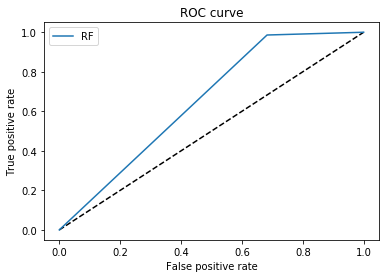

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
from src.utils.utils import get_relative_project_dir, cprint


RANDOM_STATE = 777
#training data
X = Xx.side.values.reshape(-1,1)
#labels
y = Xx.bin.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)

rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


